Shunyu Wu

# DATA LOADING

In [1]:
import os
path = 'dataset1_reaching-task/'
fname = os.path.join(path, 'Dataset1.mat')

from scipy.io import loadmat
DATA = loadmat(fname)

In [2]:
import numpy as np

In [3]:
DATA?

Type:        dict
String form:
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Apr 15 20:14:36 2014', ' <...>    [ 1.37384654,  3.40653601,  0.80143189, ...,  4.15004726,
           1.23933654,  3.31729972]])}
Length:      5
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)


In [4]:
%whos

Variable   Type        Data/Info
--------------------------------
DATA       dict        n=5
fname      str         dataset1_reaching-task/Dataset1.mat
loadmat    function    <function loadmat at 0x11ce39830>
np         module      <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
os         module      <module 'os' from '/Users<...>da3/lib/python3.7/os.py'>
path       str         dataset1_reaching-task/


In [5]:
DATA

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Apr 15 20:14:36 2014',
 '__version__': '1.0',
 '__globals__': [],
 'direction': array([[3],
        [5],
        [5],
        [2],
        [6],
        [3],
        [7],
        [4],
        [3],
        [4],
        [2],
        [1],
        [8],
        [5],
        [4],
        [2],
        [4],
        [7],
        [5],
        [2],
        [5],
        [1],
        [5],
        [4],
        [3],
        [6],
        [8],
        [1],
        [1],
        [3],
        [5],
        [7],
        [4],
        [1],
        [3],
        [7],
        [8],
        [5],
        [5],
        [2],
        [3],
        [7],
        [1],
        [8],
        [5],
        [3],
        [7],
        [4],
        [2],
        [5],
        [8],
        [8],
        [5],
        [7],
        [7],
        [4],
        [2],
        [6],
        [4],
        [6],
        [6],
        [5],
        [4],
        [3],
        [5],
   

In [6]:
firing_rate = DATA['R'].T
direction = DATA['direction']

In [7]:
firing_rate.shape

(158, 143)

In [8]:
import matplotlib.pyplot as plt

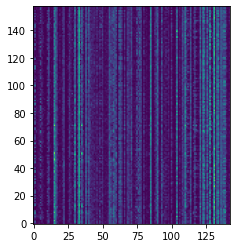

In [9]:
plt.imshow(firing_rate, origin='lower')

# 1

In [10]:
# first neuron
direction_mean = np.zeros(8)
for i in range(1,9):
    direction_mean[i-1] = firing_rate[(direction == i).flatten()][:,0].mean()

In [11]:
direction_mean

array([3.71823604, 2.33841363, 0.94966148, 0.74470821, 0.51546053,
       0.61088455, 4.36236034, 5.23958888])

Text(0, 0.5, 'firing rate mean')

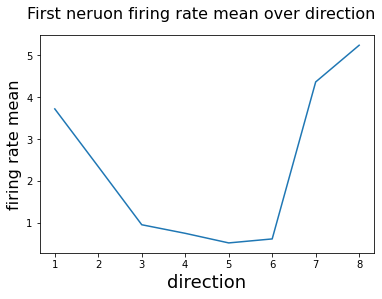

In [12]:
fig = plt.figure()
plt.plot(range(1,9), direction_mean)
fig.suptitle('First neruon firing rate mean over direction', fontsize=16)
plt.xlabel('direction', fontsize=18)
plt.ylabel('firing rate mean', fontsize=16)

# 2

In [13]:
# 2
neuron_1 = firing_rate[:,0]
neuron_2 = firing_rate[:,1]

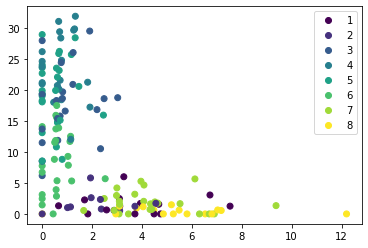

In [14]:
scatter = plt.scatter(neuron_1, neuron_2, c = direction)
classes = ['1','2','3','4','5','6','7','8']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)


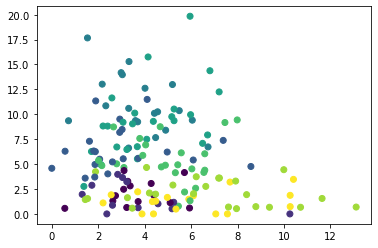

In [15]:
scatter = plt.scatter(firing_rate[:,36], firing_rate[:,10], c = direction)

# 3

In [16]:

# STANDARDIZATION before PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data_norm = StandardScaler().fit_transform(firing_rate) #normlize

pca = PCA(n_components = 2)
data_pca = pca.fit_transform(data_norm)

data_pca.shape

(158, 2)

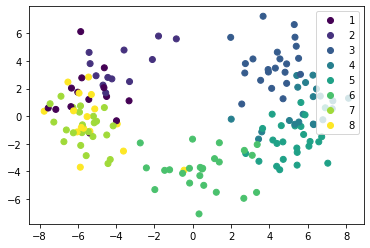

In [17]:
scatter = plt.scatter(data_pca[:,0], data_pca[:,1], c = direction)
classes = ['1','2','3','4','5','6','7','8']
plt.legend(handles=scatter.legend_elements()[0], labels=classes, loc='upper right')


In [18]:
pca.explained_variance_ratio_

array([0.17104218, 0.05861031])

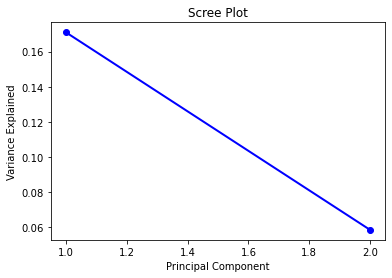

In [19]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# 4

In [20]:
trial_based = StandardScaler().fit_transform(firing_rate.T)
pca_2 = PCA(n_components = 2)
data_pca_2 = pca.fit_transform(trial_based)

data_pca_2.shape

(143, 2)

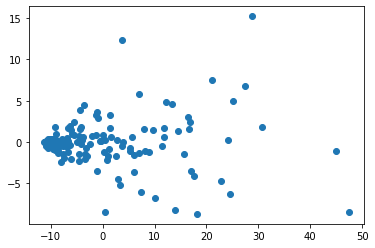

In [21]:
scatter = plt.scatter(data_pca_2[:,0], data_pca_2[:,1])


# 7 Turing neurons

In [117]:
def tuning_function(x, mu, kappa, fmax, bsl):
    # Von Mises, with kappa the concentration, mu the location
    # fmax the firing rate at pref ori, bsl the min firing rate (not the baseline, which was substracted) 
    tf = bsl + np.exp(kappa*(np.cos(x-mu)-1)) * (fmax-bsl)
    return tf

from lmfit import Model, Parameters

def fit_tc(array, init_kappa):
    x = np.linspace(0, 2*np.pi, len(array), endpoint=False)
    mod = Model(tuning_function)
    pars = Parameters()
    #               name    default           vary  min   max
    pars.add_many(('mu', x[np.argmax(array)], True, 0., 2*np.pi),
                  ('kappa', init_kappa, True,  .1, 10.),
                  ('fmax', np.max(array), True, 0.0, 2*np.max(array)+5),
                  ('bsl', np.min(array), True, 0.0, np.max(array)+5))
    out = mod.fit(array, pars, x=x, nan_policy='omit', max_nfev=50000)

    return out.best_values


In [38]:
direction_mean = np.zeros((143, 8))
for j in range(143):
    for i in range(1,9):
        direction_mean[j][i-1] = firing_rate[(direction == i).flatten()][:,j].mean()


In [89]:
direction_mean.shape

(143, 8)

In [90]:
direction_mean[1]

array([3.71823604, 2.33841363, 0.94966148, 0.74470821, 0.51546053,
       0.61088455, 4.36236034, 5.23958888])

In [97]:
out = fit_tc(direction_mean[0], 3.5)
out

{'mu': 2.505129244845642,
 'kappa': 1.4321968991549971,
 'fmax': 25.640487615934216,
 'bsl': 5.423418559415595e-08}

In [94]:
p = tuning_function(theta_more, out['mu'], out['kappa'], out['fmax'], out['bsl'])

In [75]:
theta = np.linspace(0, 2*np.pi, 8, endpoint=False)
theta_more = np.linspace(0,2*np.pi, 60, endpoint = False)

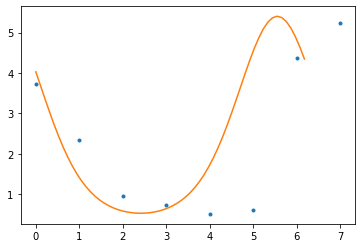

In [99]:
plt.plot(direction_mean[0], '.')
plt.plot(theta_more, p)

In [27]:
x = np.linspace(0, 2*np.pi, 8)
x

array([0.        , 0.8975979 , 1.7951958 , 2.6927937 , 3.5903916 ,
       4.48798951, 5.38558741, 6.28318531])

In [28]:
p

array([2.37499898, 2.37499898, 2.37499898, 2.37508383, 2.37501805,
       2.37499898, 2.37499898, 2.37499898])

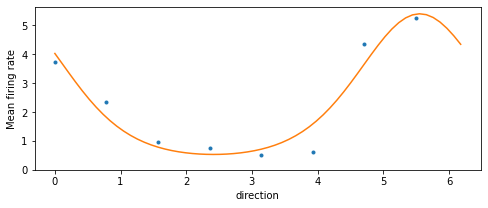

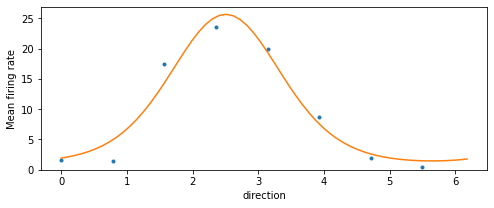

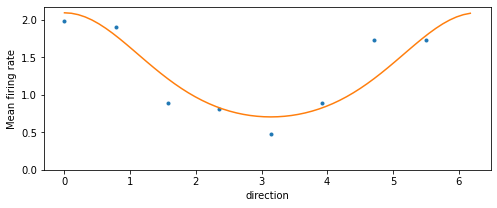

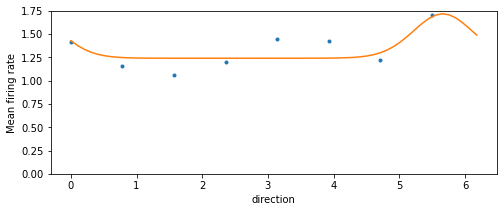

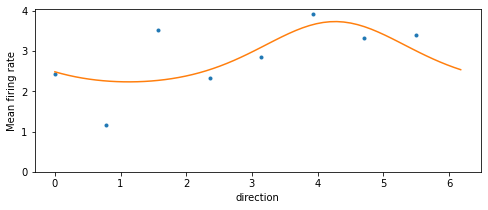

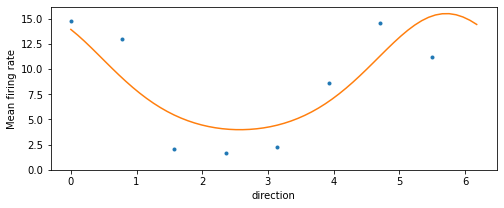

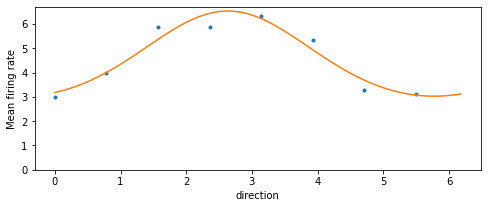

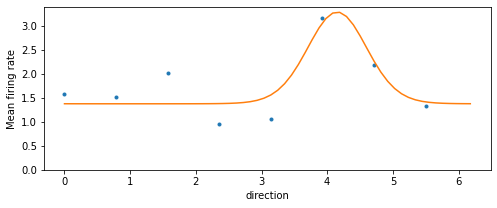

In [101]:
for i_neuron in range(8):
    p = fit_tc(direction_mean[i_neuron, :], 1.5)

    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(theta, direction_mean[i_neuron, :] , '.')
    ax.plot(theta_more, tuning_function(theta_more, **p))
    ax.set_xlabel('direction')
    ax.set_ylabel('Mean firing rate')
    ax.set_ylim(0)
    plt.show()

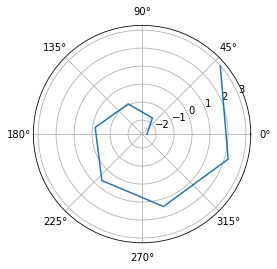

In [104]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot( theta - out['mu'])

In [118]:
mu_list = np.empty(143)
kappa_list = np.empty(143)
for i in range(143):
    out = fit_tc(direction_mean[i], 1)
    mu_list[i] = out['mu']
    kappa_list[i] = out['kappa']

(array([16.,  4., 12., 24., 24., 15.,  6.,  8., 17., 17.]),
 array([  0.,  36.,  72., 108., 144., 180., 216., 252., 288., 324., 360.]),
 <BarContainer object of 10 artists>)

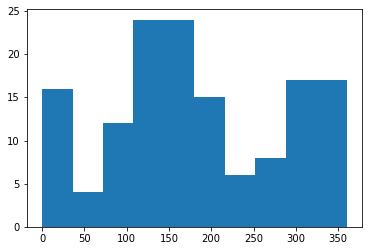

In [116]:
# distrubition of mu
plt.hist(mu_list*180/np.pi)


(array([72., 24.,  3.,  8.,  2.,  1.,  2.,  2.,  1., 28.]),
 array([ 0.1 ,  1.09,  2.08,  3.07,  4.06,  5.05,  6.04,  7.03,  8.02,
         9.01, 10.  ]),
 <BarContainer object of 10 artists>)

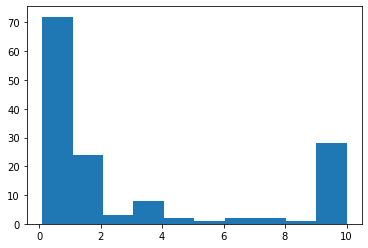

In [119]:
plt.hist(kappa_list)